In [2]:
%load_ext autoreload
%autoreload 2

In [23]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import mne
import torch
from torch.fft import fft, rfft, fftshift
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import butter, filtfilt, hilbert

import src.utils.sleep_utils as utils

In [4]:
edf_path = "data/MPSD1 Baseline.edf"
bout_length = 10
bout_context = 5
causal = False

In [5]:
sample = mne.io.read_raw_edf("data/MPSD1 Baseline.edf", preload=True, verbose="WARNING")

In [6]:
sample.info.ch_names

['Activity',
 'BattVolt',
 'EEG',
 'EMG',
 'OnTime',
 'SignalStr',
 'Temp',
 'Signal-Sleep']

In [24]:
x = sample.get_data("Activity")[0, :]

In [58]:
pd.Series(x).rolling(window=500, step=500, center=True).max().shape

(86400,)

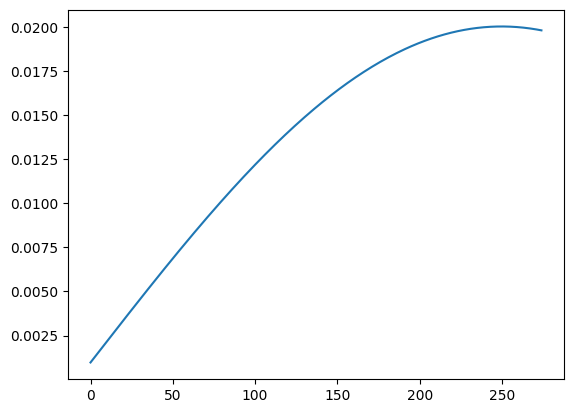

In [22]:
plt.plot(sample.get_data("Activity")[0, :275])

In [26]:
fs = 500.0                        # Hz, your sampling rate
f0 = 0.5                         # Hz, carrier
t = np.arange(len(x))/fs

# 1) Band-pass around the carrier
lo, hi = 0.2, 0.8                # tune as needed
b, a = butter(4, [lo, hi], btype='band', fs=fs)
x_bp = filtfilt(b, a, x)

# 2) Hilbert envelope (quick)
analytic = hilbert(x_bp)
envelope_hilbert = np.abs(analytic)
phase = np.unwrap(np.angle(analytic))
f_inst = np.diff(phase)/(2*np.pi) * fs     # len N-1

# Smooth envelope if desired
b_lp, a_lp = butter(3, 0.1, btype='low', fs=fs)   # tracks ≤0.1 Hz amplitude changes
env_smooth = filtfilt(b_lp, a_lp, envelope_hilbert)

# 3) Complex demodulation (I/Q)
z = x_bp * np.exp(-1j*2*np.pi*f0*t)
b_b, a_b = butter(4, 0.1, btype='low', fs=fs)     # baseband LPF sets tracking speed
baseband = filtfilt(b_b, a_b, z)
amplitude_iq = np.abs(baseband)                   # robust envelope
phase_iq = np.angle(baseband)

In [83]:
utils.extract_activity_signal(sample)[]

SyntaxError: invalid syntax (4238642398.py, line 1)

In [86]:
df.assign(activity= utils.extract_activity_signal(sample).values)

,sleep,start,stop,activity
0,S,0,5000,0.020017
1,S,5000,10000,0.019345
2,S,10000,15000,0.018873
3,S,15000,20000,0.018527
4,S,20000,25000,0.018263
...,...,...,...,...
8635,S,43175000,43180000,0.082301
8636,S,43180000,43185000,0.034317
8637,S,43185000,43190000,0.026019
8638,S,43190000,43195000,0.022741


In [99]:
sleep_string = "".join(df.sleep.values)

In [104]:
df.sleep[0:3]

0    S
1    S
2    S
Name: sleep, dtype: object

In [ ]:
df.index.map(lambda x: sleep_string[max(x-2, 0):x+3])

AAAAA    4198
SSSSS    2515
RRRRR     174
ASSSS     162
SSSSA     125
         ... 
AAAAR       1
AAARR       1
AARRR       1
ARRRR       1
XXXSS       1
Name: count, Length: 118, dtype: int64

In [109]:
df = utils.create_sleep_stage_dataframe(sample)
df_subsampled = utils.subsample_sleep_dataframe(df)

In [110]:
df_subsampled

,sleep,start,stop,activity,context
9,S,45000,50000,0.017556,SSSSR
11,R,55000,60000,0.017417,SSRRR
12,R,60000,65000,0.017363,SRRRR
13,R,65000,70000,0.017319,RRRRR
14,R,70000,75000,0.017282,RRRRR
...,...,...,...,...,...
8601,S,43005000,43010000,0.020600,SSSSA
8626,R,43130000,43135000,0.024747,SSRRR
8627,R,43135000,43140000,0.028305,SRRRA
8628,R,43140000,43145000,0.034632,RRRAS


In [111]:
train_df, test_df = train_test_split(df_subsampled, stratify=df_subsampled.sleep, test_size=0.255, random_state=0)

In [112]:
train_df.sort_index().loc[lambda df: df.start.diff() < 10000.0].sleep.value_counts()

sleep
R    168
S     15
A      8
Name: count, dtype: int64

In [113]:
row

NameError: name 'row' is not defined

In [114]:
row = train_df.iloc[0]
buffer = 500 * 10 * 2
sample.get_data(picks=["EEG", "EMG"])[:, row.start-buffer:row.stop+buffer]


array([[-2.40329595e-05, -2.75425345e-05, -3.30357824e-05, ...,
        -1.29701686e-06,  5.11177234e-06,  6.02731365e-06],
       [ 1.99130236e-05, -6.63767453e-06, -1.80819409e-05, ...,
        -1.91500725e-05, -9.84206912e-06,  3.43327993e-06]],
      shape=(2, 25000))

In [121]:
train, test = utils.process_edf(edf_path, signals=["EEG", "EMG"], bout_length=bout_length, bout_context=bout_context, causal=causal)

Extracting EDF parameters from /Users/nicholasworley/projects/rembler/data/MPSD1 Baseline.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43199999  =      0.000 ... 86399.998 secs...


In [ ]:
test_signals = np.stack(test.signal.values)
test_labels = np.stack(test.sleep.map(lambda x: utils.stage_to_int[x]).values)


In [129]:
x

array([[[-7.01152056e-05, -6.79789425e-05, -4.57007706e-05, ...,
          8.21698329e-05,  6.21805142e-05,  5.91287098e-05],
        [-9.43770504e-05, -8.99519341e-05, -9.20881971e-05, ...,
          6.88944839e-05,  5.31776913e-05,  1.07576104e-05]],

       [[-3.82238499e-05, -6.37064164e-05, -7.89654383e-05, ...,
         -4.63111315e-05, -4.96681163e-05, -5.19569696e-05],
        [ 1.67086290e-05,  1.86923018e-05,  1.24361028e-05, ...,
         -9.84206912e-06, -6.33249409e-06,  6.17990387e-06]],

       [[-1.02464332e-04, -1.12230106e-04, -1.19554437e-04, ...,
         -1.21538109e-04, -1.40917067e-04, -1.28709850e-04],
        [-1.71663996e-05, -1.09102007e-05, -1.71663996e-05, ...,
          1.90737774e-06,  4.80659190e-06,  5.56954299e-06]],

       ...,

       [[ 4.46326390e-05,  5.19569696e-05,  5.08888380e-05, ...,
          5.04310674e-05,  5.05836576e-05,  5.53139544e-05],
        [-1.28938735e-05, -1.18257420e-05, -1.16731518e-05, ...,
          1.91500725e-05,  9.46822

/Users/nicholasworley/projects/rembler/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nicholasworley/projects/rembler/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


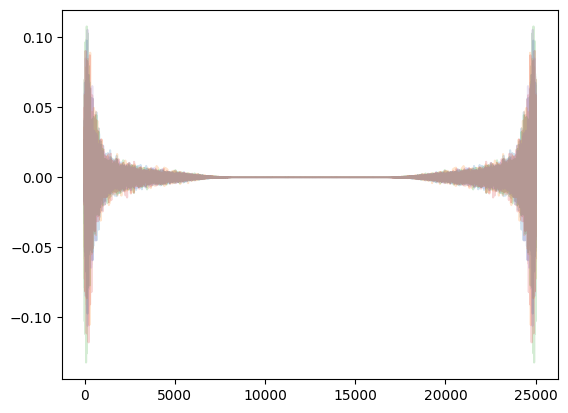

In [43]:
for i in range(5):
    plt.plot(scipy.fft.fft(df_final[df_final.sleep == "S"].iloc[i].signal[0]), alpha=.2)

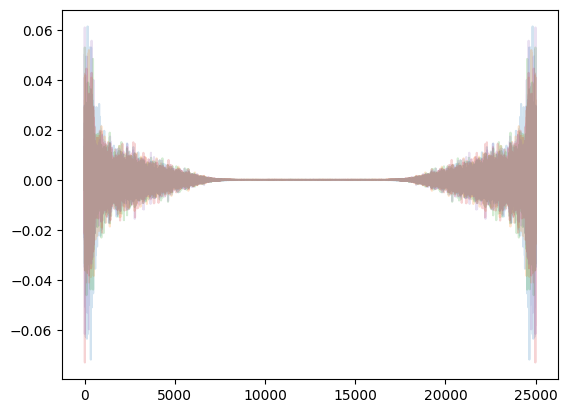

In [88]:
for i in range(5):
    plt.plot(scipy.fft.fft(df_final[df_final.sleep == "R"].iloc[i].signal[0]), alpha=.2)

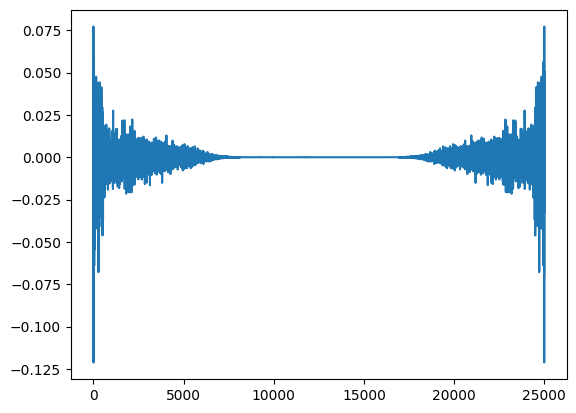

In [91]:
plt.plot(scipy.fft.fft(np.stack(df_final[df_final.sleep == "A"].signal)[0, 0, :]))

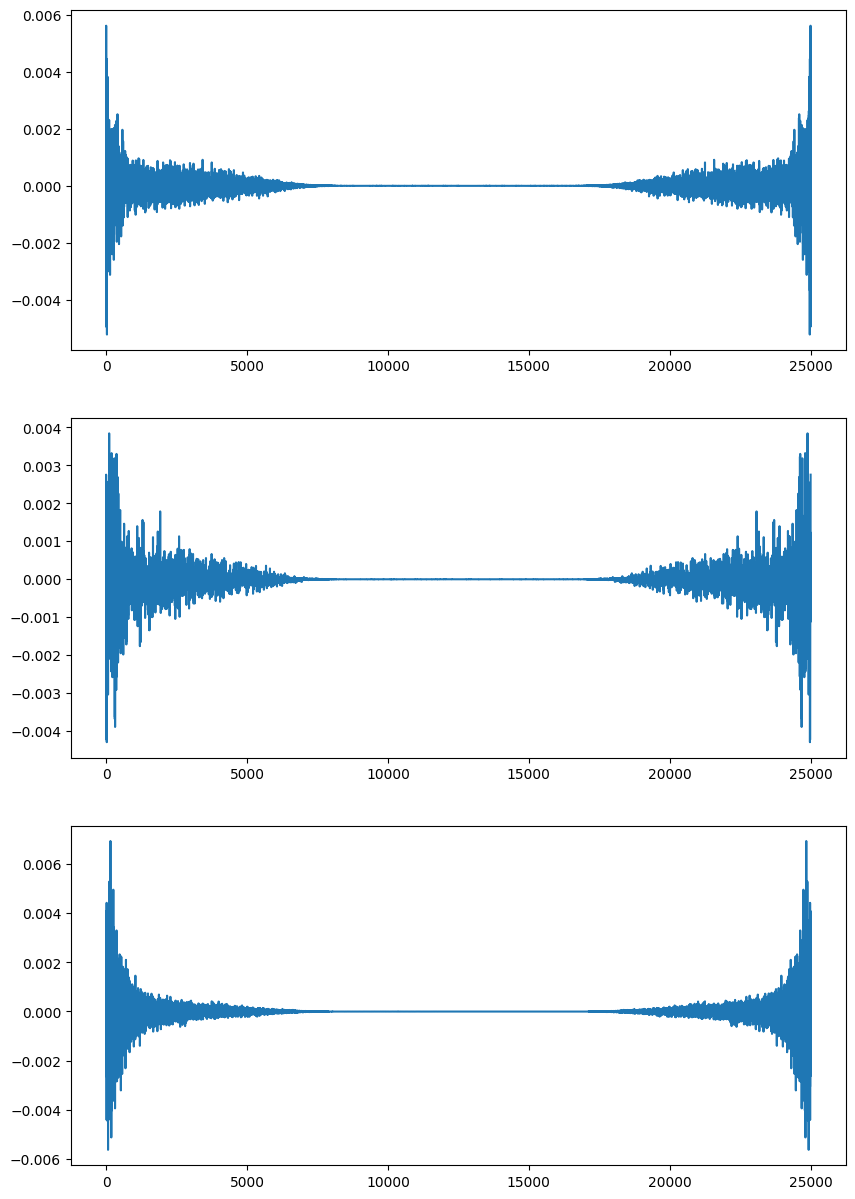

In [101]:
fig, axes = plt.subplots(3,1, figsize=(10,15))
axes[0].plot(scipy.fft.fft(np.stack(df_final[df_final.sleep == "A"].signal)[:, 0, :]).mean(axis=0), alpha=1)
axes[1].plot(scipy.fft.fft(np.stack(df_final[df_final.sleep == "R"].signal)[:, 0, :]).mean(axis=0), alpha=1)
axes[2].plot(scipy.fft.fft(np.stack(df_final[df_final.sleep == "S"].signal)[:, 0, :]).mean(axis=0), alpha=1)

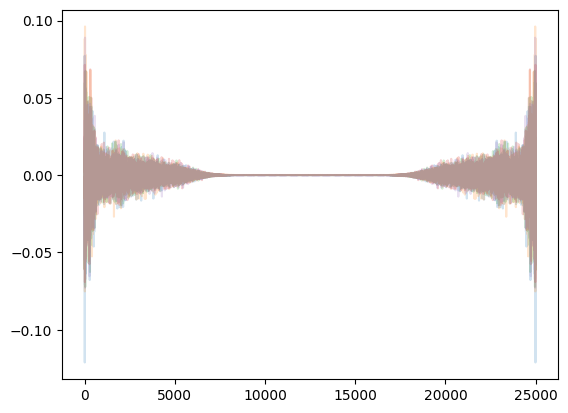

In [45]:
for i in range(5):
    plt.plot(scipy.fft.fft(df_final[df_final.sleep == "A"].iloc[i].signal[0]), alpha=.2)

array([array([[-5.28725109e-05, -5.98916609e-05, -3.68505379e-05, ...,
               -1.41374838e-04, -1.20775158e-04, -7.40825513e-05],
              [ 5.28725109e-05,  1.33516442e-05, -3.24254215e-05, ...,
                2.02182040e-05, -6.02731365e-06, -2.38803693e-05]],
             shape=(2, 25000))                                        ,
       array([[ 1.26726177e-04,  1.28252079e-04,  1.22453651e-04, ...,
               -7.09544518e-06, -1.54879072e-05, -2.76951247e-05],
              [-6.17990387e-06,  7.70580606e-06,  4.06652934e-05, ...,
               -4.06652934e-05, -3.94445716e-05, -3.18150607e-05]],
             shape=(2, 25000))                                        ,
       array([[-3.89105058e-06,  2.82291905e-06, -1.14442664e-06, ...,
               -4.89051652e-05, -1.50301366e-05,  7.09544518e-06],
              [-2.25070573e-05, -1.82345312e-05,  1.04524300e-05, ...,
                7.46929122e-05,  4.02075227e-05,  6.15701534e-05]],
             shape=(2, 25

In [19]:
df_final.assign(signal=df_final.apply(lambda row: utils.get_bout_signal(signal, 
row, leading_buffer=500*10*2, trailing_buffer=500*10*2), axis=1))

,sleep,start,stop,signal
9,S,45000,50000,"[[6.485084306096118e-06, 1.625085831998183e-05..."
11,R,55000,60000,"[[-0.00012748912794689846, -0.0001442740520332..."
12,R,60000,65000,"[[7.400625619897903e-06, -8.392462043181647e-0..."
13,R,65000,70000,"[[-1.602197299152986e-06, -7.095445181963698e-..."
14,R,70000,75000,"[[8.567940794995054e-05, 7.591363393606485e-05..."
...,...,...,...,...
8601,S,43005000,43010000,"[[0.00011635004196231036, 0.000113145647364004..."
8626,R,43130000,43135000,"[[0.00011787594415198, 0.00010215915159838269,..."
8627,R,43135000,43140000,"[[-5.043106736858154e-05, -4.814221408407707e-..."
8628,R,43140000,43145000,"[[1.5487907225147006e-05, 2.357518883039611e-0..."


In [ ]:
def get_bout_signal(full_signals, row, leading_buffer=0, trailing_buffer=0):
    return full_signals[:, row.start-leading_buffer:row.stop+trailing_buffer]

def determine_buffering(bout_length, bout_context, sampling_rate, causal=False):
    if causal:
        leading_buffer = (bout_context - 1) * bout_length * sampling_rate
        trailing_buffer = 0
    else:
        leading_buffer = (bout_context - 1) / 2 * bout_length * sampling_rate
        trailing_buffer = leading_buffer
    assert leading_buffer % 1 == 0, "Leading buffer must be an integer number of samples"
    assert trailing_buffer % 1 == 0, "Trailing buffer must be an integer number of samples"
    return leading_buffer, trailing_buffer

In [ ]:
def process_edf(edf_path: str, bout_length: int = 10, bout_context: int = 5, causal=False) -> pd.DataFrame:
    """
    Process the EDF file and extract relevant data
    """
    # Load the EDF file
    edf_data = mne.io.read_raw_edf(edf_path, preload=True)
    # Extract sleep stages
    sleep_stages = utils.extract_sleep_stages(edf_data)
    # Create a DataFrame with sleep stages and time intervals
    df = (pd.Series(sleep_stages)
    .map(int_to_stage)
    .rename("sleep")
    .to_frame()
    .assign(start = lambda df: df.index * 5000)
    .assign(stop = lambda df: (df.index +1 )* 5000)
    )


In [147]:
sample.info['sfreq']

500.0

In [ ]:
utils.subsample_sleep_dataframe(utils.create_sleep_stage_dataframe(sample))

,sleep,start,stop
9,S,45000,50000
11,R,55000,60000
12,R,60000,65000
13,R,65000,70000
14,R,70000,75000
...,...,...,...
8601,S,43005000,43010000
8626,R,43130000,43135000
8627,R,43135000,43140000
8628,R,43140000,43145000


In [148]:
sample.n_times / sample.info['sfreq'] / 10

np.float64(8640.0)

In [149]:
43_200_000 / (500) / 10

8640.0

In [77]:
numeric_sleep_stages = sample["Signal-Sleep"][0][0, np.arange(2500, sample.n_times, 5000)]

In [150]:
numeric_sleep_stages.shape

(8640,)

In [151]:
sleep_stages = utils.extract_sleep_stages(sample)

In [152]:
int_to_stage = {0: "A",
                1: "R",
                2: "S",
                3: "X",
               }

In [153]:
df = pd.Series(sleep_stages).map(int_to_stage).rename("sleep").to_frame().assign(start = lambda df: df.index * 5000).assign(stop = lambda df: (df.index +1 )* 5000)

In [154]:
df.sleep.value_counts()

sleep
A    4882
S    3262
R     344
X     152
Name: count, dtype: int64

In [140]:
sub_sample = df[df.sleep != "X"].groupby("sleep").sample(n=344, random_state=0).sort_index()

In [142]:
sub_sample.sleep.value_counts()

sleep
S    344
R    344
A    344
Name: count, dtype: int64

In [83]:
samples = df

In [123]:
idx = 7998
samples.loc[idx]

sleep           A
start    39990000
stop     39995000
Name: 7998, dtype: object

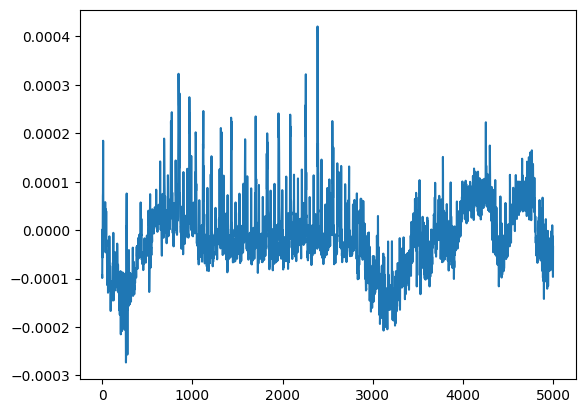

In [124]:
plt.plot(sample['EMG'][0][0, df.loc[idx, 'start']:df.loc[idx, 'stop']])

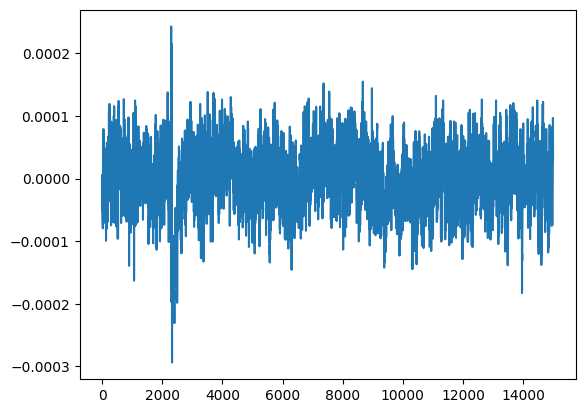

In [125]:
plt.plot(sample['EEG'][0][0, df.loc[idx-1, 'start']:df.loc[idx+1, 'stop']])

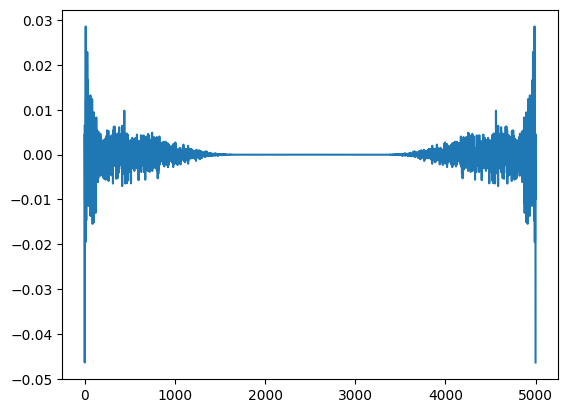

In [126]:
plt.plot(
(fft(torch.from_numpy(sample['EEG'][0][0, df.loc[idx, 'start']:df.loc[idx, 'stop']]))
))

array([1.69375143e-05-0.00000000e+00j, 2.27372609e-05+5.71374598e-06j,
       1.79122173e-05-3.02120074e-06j, ...,
       1.75492884e-05-9.19143462e-07j, 1.79122173e-05+3.02120074e-06j,
       2.27372609e-05-5.71374598e-06j])

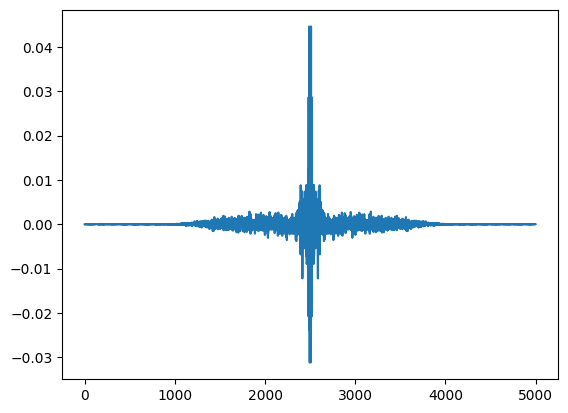

In [23]:
plt.plot(fftshift(fft(sample['EEG'][0][0, df.loc[42, 'start']:df.loc[42, 'stop']])))

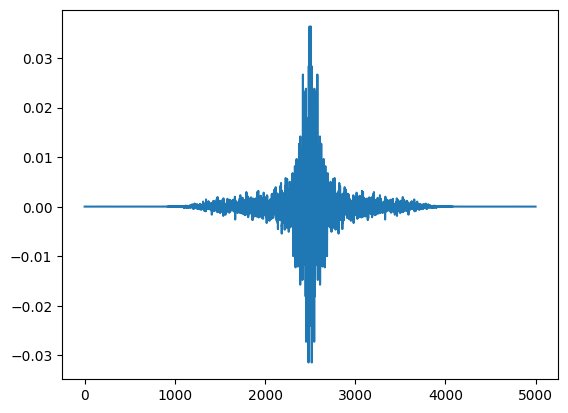

In [74]:
plt.plot(fftshift(fft(sample['EEG'][0][0, df.loc[800, 'start']:df.loc[800, 'stop']])))

In [24]:
pd.Series(scipy.fft.fft(np.digitize(numeric_sleep_stages, bins = [1.5,2.5, 3.5])).value_counts().sort_index())

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [25]:
pd.Series(utils.extract_sleep_stages(sample)).value_counts()

3    191
0    169
Name: count, dtype: int64

In [26]:
sample.get_data(picks='Signal-Sleep', start=0, stop=5000)[0].mean()

np.float64(0.9525537349619629)

In [27]:
sample.ch_names

['Activity', 'EEG', 'EMG', 'Temp', 'Signal-Sleep']

In [28]:
sample['Signal-Sleep'][0][0, 10000:]

array([ 9.99542222, 10.00781174, 10.02014211, ...,  1.03749911,
        1.02478794,  1.01213561], shape=(1790000,))

In [29]:
offset = 200000
sampling_freq = 500
duration = 10

In [30]:
arr = sample['EEG'][0][0][offset:offset+500*10*3]

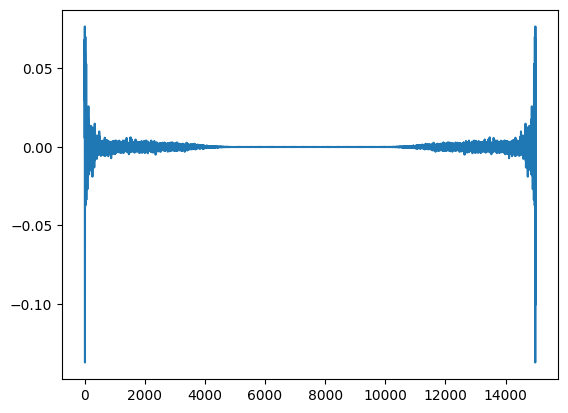

In [31]:
plt.plot(scipy.fft.fft(arr))

In [ ]:
plt.plot(sample['EEG'][0][0][offset:offset+500*10*1])
plt.ylim(-.2/1000, .200/1000)

In [ ]:
plt.plot(sample['EMG'][0][0][offset:offset+500*10*1])

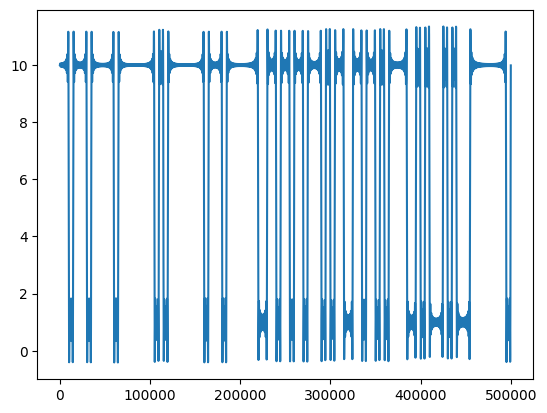

In [32]:
plt.plot(sample['Signal-Sleep'][0][0, 1000000:1500000])

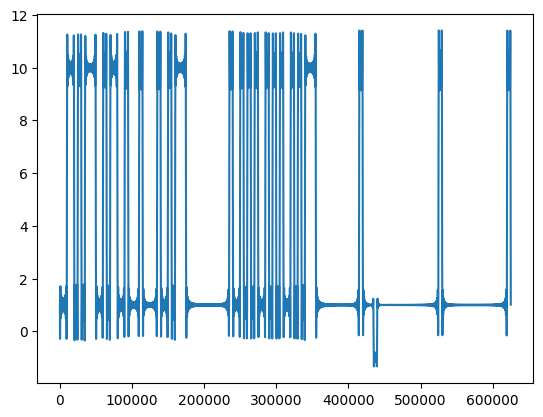

In [33]:
plt.plot(sample['Signal-Sleep'][0][0, :500*10*125])

~ 10 is Artifact
~ 3 is Sleep
~ 2 is REM
~ 1 Awake


In [ ]:
(sample["EEG"][1]).shape

In [ ]:
sample["eeg"][1].shape

In [76]:
import h5py
import numpy as np


In [123]:
f

<Closed HDF5 file>

In [126]:
f = h5py.File("mytestfile.hdf5", "r")



In [125]:
f

<Closed HDF5 file>

In [119]:
f.close()

In [127]:
"mydataset" in f

True

In [133]:
x = f["mydataset"]

In [137]:
np.array(x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)